In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sns


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ML_files/Time Series Forecasting for Demand of Store Items/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/ML_files/Time Series Forecasting for Demand of Store Items/test.csv")

In [ ]:
df.head(10)

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
5  2013-01-06      1     1     12
6  2013-01-07      1     1     10
7  2013-01-08      1     1      9
8  2013-01-09      1     1     12
9  2013-01-10      1     1      9

In [ ]:
df.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

In [ ]:
df.isnull()

date  store   item  sales
0       False  False  False  False
1       False  False  False  False
2       False  False  False  False
3       False  False  False  False
4       False  False  False  False
...       ...    ...    ...    ...
912995  False  False  False  False
912996  False  False  False  False
912997  False  False  False  False
912998  False  False  False  False
912999  False  False  False  False

[913000 rows x 4 columns]

In [ ]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [ ]:
df['store'].isnull().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:

df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)                         
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

In [ ]:
train_df.head()

date  store  item  sales  year  month  day  weekday
0 2013-01-01      1     1     13  2013      1    1        1
1 2013-01-02      1     1     11  2013      1    2        2
2 2013-01-03      1     1     14  2013      1    3        3
3 2013-01-04      1     1     13  2013      1    4        4
4 2013-01-05      1     1     10  2013      1    5        5

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     1734 non-null   datetime64[ns]
 1   store    1734 non-null   int64         
 2   item     1734 non-null   int64         
 3   sales    1734 non-null   int64         
 4   year     1734 non-null   int64         
 5   month    1734 non-null   int64         
 6   day      1734 non-null   int64         
 7   weekday  1734 non-null   int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 108.5 KB


In [ ]:
test_df.head()

date  store  item  sales  year  month  day  weekday
0 2017-10-01      1     1     21  2017     10    1        6
1 2017-10-02      1     1     12  2017     10    2        7
2 2017-10-03      1     1     18  2017     10    3        1
3 2017-10-04      1     1     15  2017     10    4        2
4 2017-10-05      1     1     20  2017     10    5        3

##Data Exploration

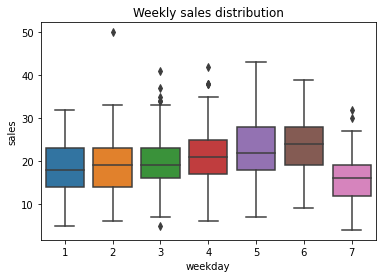

In [ ]:
plot = sns.boxplot(x='weekday', y='sales', data=df)
_ = plot.set(title='Weekly sales distribution')

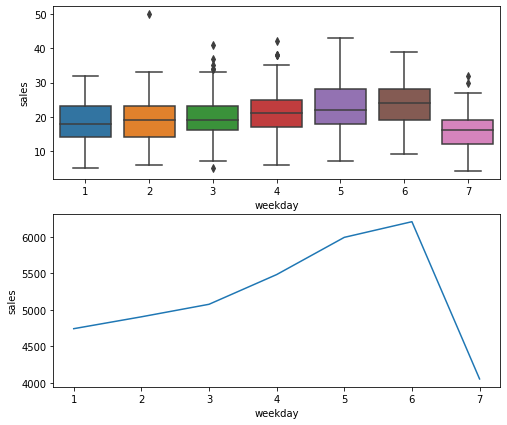

In [ ]:
weekday_agg = df.groupby('weekday')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(8,7))
sns.boxplot(x='weekday', y='sales', data=df, ax=axs[0])
_ = sns.lineplot(x='weekday', y='sales', data=weekday_agg, ax=axs[1])

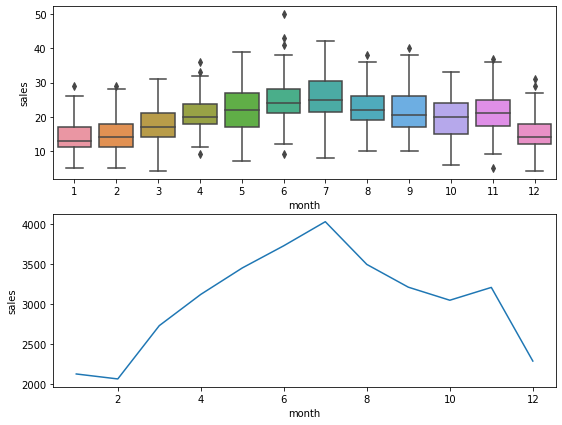

In [ ]:
monthly_agg = df.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='month', y='sales', data=df, ax=axs[0])
_ = sns.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

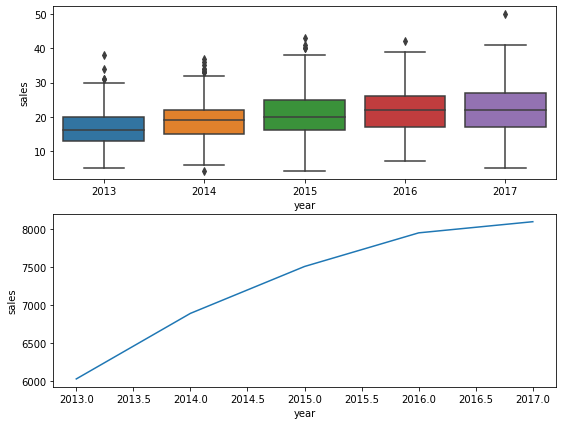

In [ ]:
yearly_agg = df.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='year', y='sales', data=df, ax=axs[0])
_ = sns.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

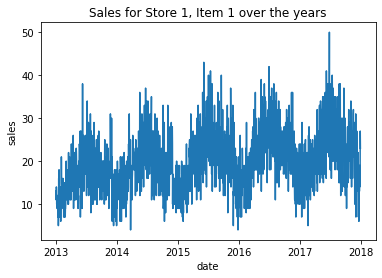

In [ ]:
plot = sns.lineplot(x='date', y='sales', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')

In [ ]:
df_test.head()

id        date  store  item
0   0  2018-01-01      1     1
1   1  2018-01-02      1     1
2   2  2018-01-03      1     1
3   3  2018-01-04      1     1
4   4  2018-01-05      1     1

In [ ]:
train_df['year'].value_counts()

2016    366
2013    365
2014    365
2015    365
2017    273
Name: year, dtype: int64

##Forecasting Metrics
####a. MAE
####b. RMSE
####c. MAPE

In [ ]:
def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=test_df['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

##Time Series Decomposition Plot

#### For Determining Additive or Multiplicative property of three components.
####a. Trend
####b. Seasonality
####c. Error

In [ ]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

store  item  sales  year  month  day  weekday
date                                                     
2013-01-01      1     1   13.0  2013      1    1        1
2013-01-02      1     1   11.0  2013      1    2        2
2013-01-03      1     1   14.0  2013      1    3        3
2013-01-04      1     1   13.0  2013      1    4        4
2013-01-05      1     1   10.0  2013      1    5        5

<Figure size 432x288 with 0 Axes>

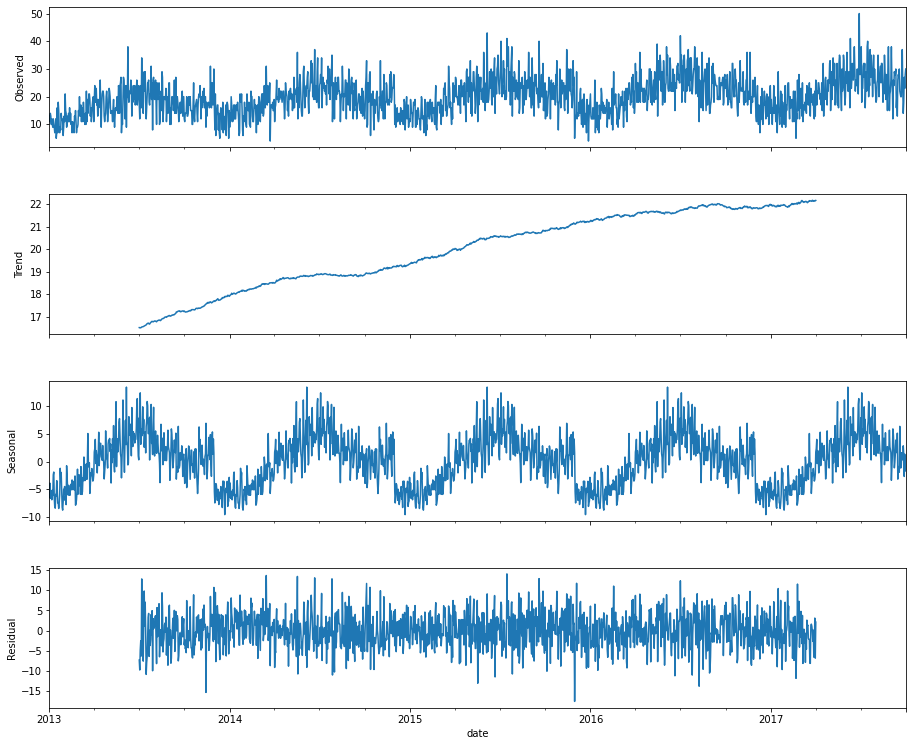

In [ ]:
result = seasonal_decompose(ts_decomp_df['sales'], model='additive', freq=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

###1. Exponential Smoothing Model
####1. Single Exponential Smoothing
####2. Double Exponential Smoothing
####3. Triple Exponential Smoothing
#####a. Holt Winter's Triple Exponential Smoothing Model (without damping)
#####b. Holt Winter's Triple Exponential Smoothing Model (with damping)

In [ ]:
hw_train_df = train_df[['date', 'sales']].set_index('date')
hw_test_df = test_df[['date', 'sales']].set_index('date')

# Apply Triple Exponential Smoothing

hw_model_1 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12)
hw_fit_1 = hw_model_1.fit(use_boxcox=False, remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]), 
                       name='pred_sales').reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, damped=True)
hw_fit_2 = hw_model_2.fit(use_boxcox=False, remove_bias=False)
pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]), 
                       name='pred_sales').reset_index()
print('Forecasts made, ready for evaluation')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Forecasts made, ready for evaluation


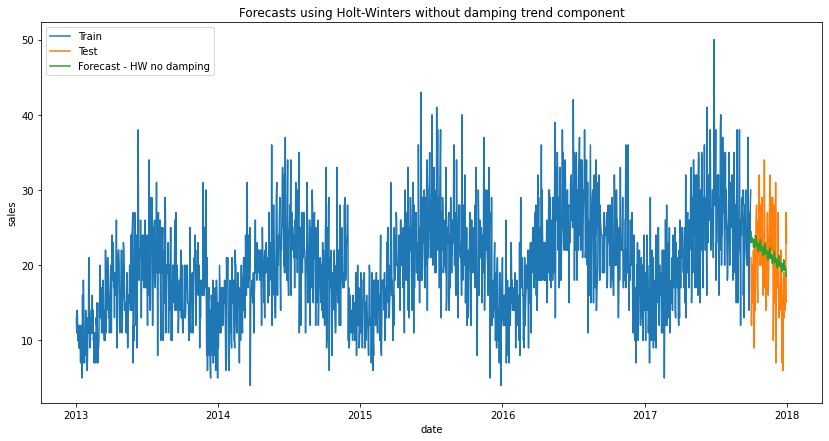

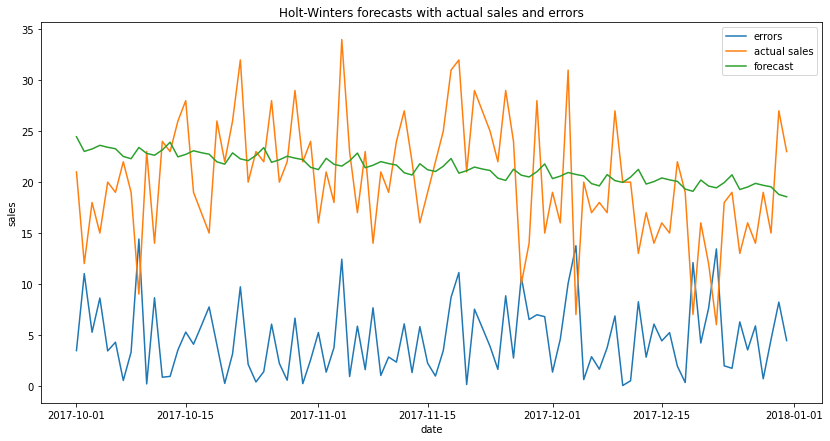

total_sales  total_pred_sales  holt_winters_overall_error  \
model                                                                     
Holt-Winters         1861       1966.695466                 -105.695466   

                  MAE      RMSE       MAPE  
model                                       
Holt-Winters  4.62932  5.827427  22.885408

In [ ]:
# Merge predictions and actual sales into one df
errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'sales', 'pred_sales']]
errors_df_hw['errors'] = errors_df_hw.sales - errors_df_hw.pred_sales
errors_df_hw.insert(0, 'model', 'Holt-Winters')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()


plt.figure(figsize=(14,7))
plt.plot(errors_df_hw['date'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['date'], errors_df_hw['sales'], label='actual sales')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters forecasts with actual sales and errors')
plt.show()

result_df_hw = errors_df_hw.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_hw

In [ ]:
MAE_hwwtd=mae(np.abs(errors_df_hw['errors']))
RMSE_hwwtd=rmse(np.abs(errors_df_hw['errors'])) 
MAPE_hwwtd=mape(np.abs(errors_df_hw['errors']))
print(MAE_hwwtd)
print(RMSE_hwwtd)
print(MAPE_hwwtd)

4.6293201270398665
5.82742657900638
22.88540847327608


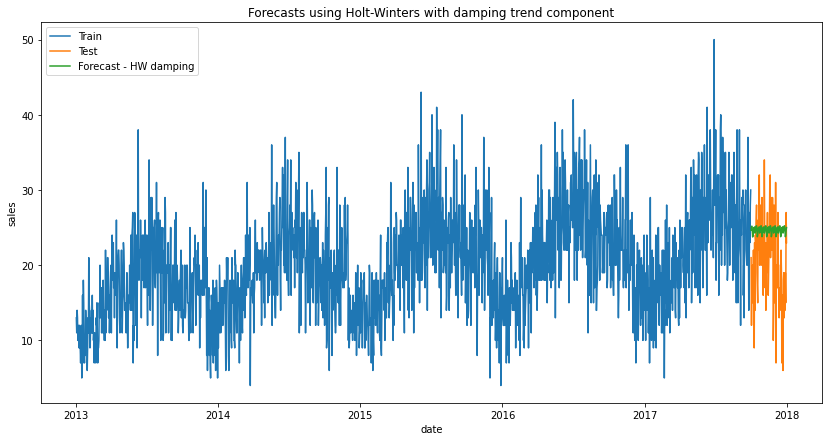

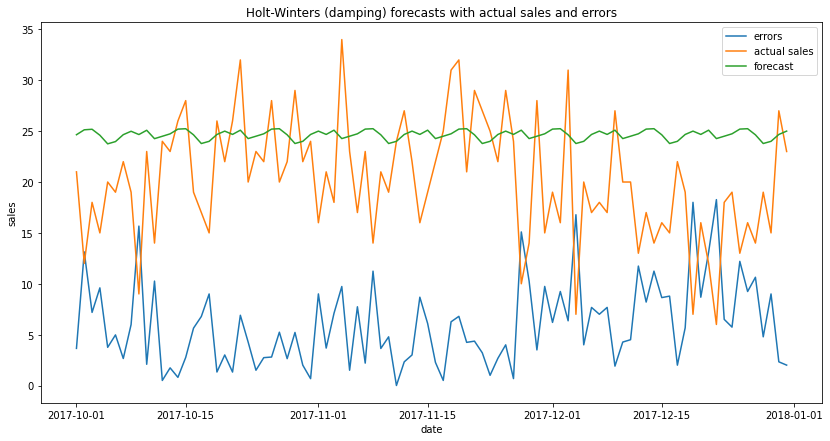

total_sales  total_pred_sales  \
model                                                
Holt-Winters-Damped         1861       2267.672189   

                     holt_winters_overall_error       MAE      RMSE       MAPE  
model                                                                           
Holt-Winters-Damped                 -406.672189  6.016185  7.319618  29.741486

In [ ]:
# Merge predictions and actual sales into one df
errors_df_hwd = pd.merge(test_df, pred_fit_2, left_on='date', right_on='index')
errors_df_hwd = errors_df_hwd[['date', 'sales','pred_sales']]
errors_df_hwd['errors'] = errors_df_hwd.sales - errors_df_hwd.pred_sales
errors_df_hwd.insert(0, 'model', 'Holt-Winters-Damped') 


# Evaluate the predictions for Holt-Winters with damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='Forecast - HW damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters with damping trend component')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(errors_df_hwd['date'], np.abs(errors_df_hwd['errors']), label='errors')
plt.plot(errors_df_hwd['date'], errors_df_hwd['sales'], label='actual sales')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters (damping) forecasts with actual sales and errors')
plt.show()

result_df_hwd = errors_df_hwd.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_hwd

In [ ]:
MAE_htd=mae(np.abs(errors_df_hwd['errors']))
RMSE_htd=rmse(np.abs(errors_df_hwd['errors'])) 
MAPE_htd=mape(np.abs(errors_df_hwd['errors']))
print(MAE_htd)
print(RMSE_htd)
print(MAPE_htd)

6.016185309353968
7.319618029643596
29.741485677623057


###2. Autoregressive Integrated Moving Average - ARIMA Model
###Steps
####1. Check Stationarity
##### a. Plotting Rolling Statistics
##### b. Augmented Dickey Fuller Test 
##### c. ACF and PACF plots 
####2. Differencing
####3. Model Building

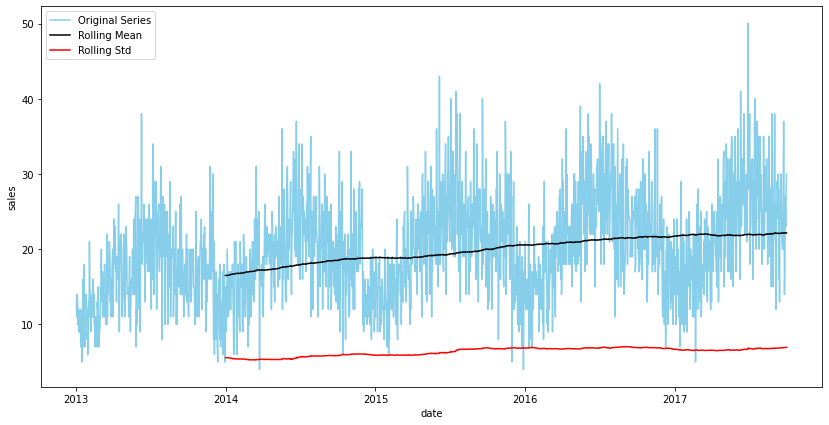

Test statistic = -2.937
P-value = 0.041
Critical values :
	1%: -3.434179908502461 - The data is not stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


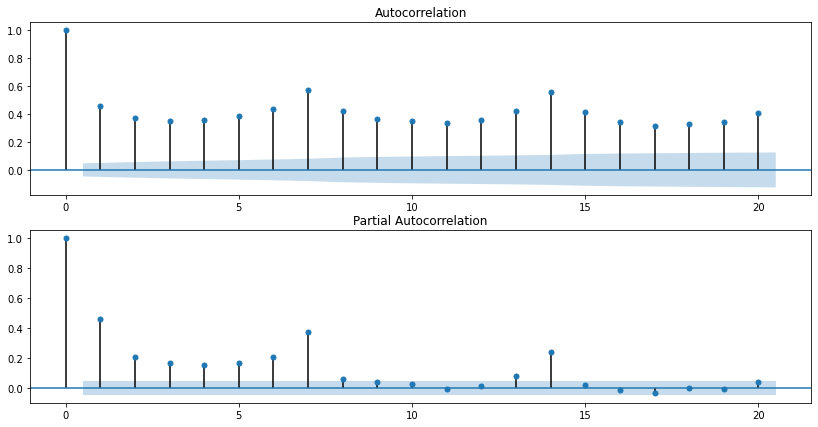

In [ ]:
arima_df = train_df[['date', 'sales']].set_index('date')
arima_test_df = test_df[['date', 'sales']].set_index('date')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()
    
    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")
    
    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))
        
    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)
    
test_stationarity(arima_df.sales)

###Step 2: Differencing
####Differencing: Seasonal or cyclical patterns can be removed by substracting periodical values. If the data is 12-month seasonal, substracting the series with a 12-lag difference series will give a “flatter” series. 

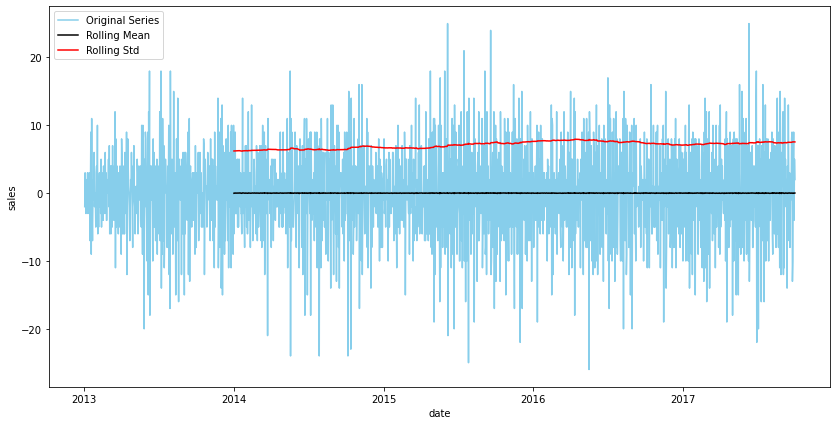

Test statistic = -12.326
P-value = 0.000
Critical values :
	1%: -3.434179908502461 - The data is  stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


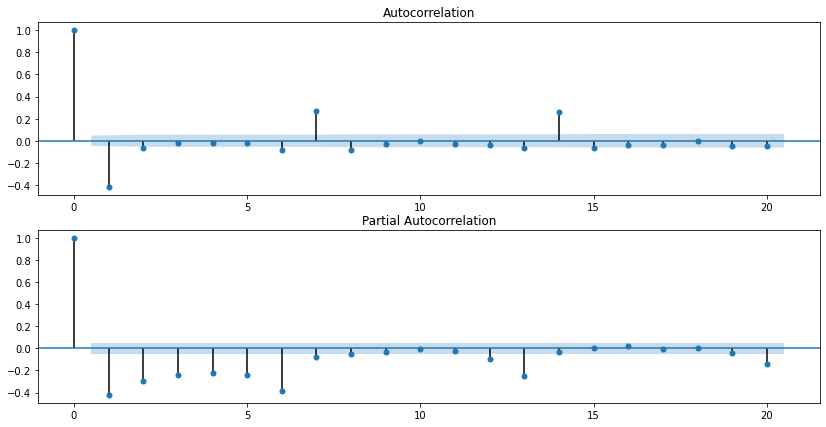

In [ ]:
first_difference = arima_df.sales - arima_df.sales.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference.sales)

In [ ]:
arima_model61 = ARIMA(arima_df.sales, (6,1,1)).fit(disp=False)
print(arima_model61.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1733
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5306.599
Method:                       css-mle   S.D. of innovations              5.168
Date:                Wed, 25 May 2022   AIC                          10631.197
Time:                        00:44:45   BIC                          10680.316
Sample:                    01-02-2013   HQIC                         10649.364
                         - 09-30-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0072      0.023      0.314      0.754      -0.038       0.052
ar.L1.D.sales    -0.6038      0.063     -9.658      0.000      -0.726      -0.481
ar.L2.D.sales    -0.6031      0.050    -

###Plotting the residuals using ACF and PACF

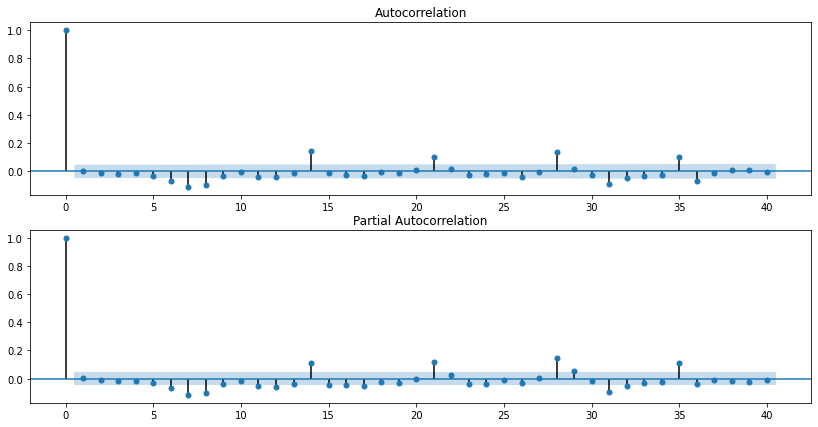

In [ ]:
residuals = arima_model61.resid
# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

###3. Seasonal ARIMA (SARIMA) Model

In [ ]:
# fit the model
sarima_model = SARIMAX(arima_df.sales, order=(6, 1, 0), seasonal_order=(6, 1, 0, 7), 
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
arima_test_df['pred_sales'] = sarima_fit.predict(start=arima_test_df.index[0],
                                                 end=arima_test_df.index[-1], dynamic= True)
#plot = sarima_fit.plot_diagnostics(figsize=(14,7))
#plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


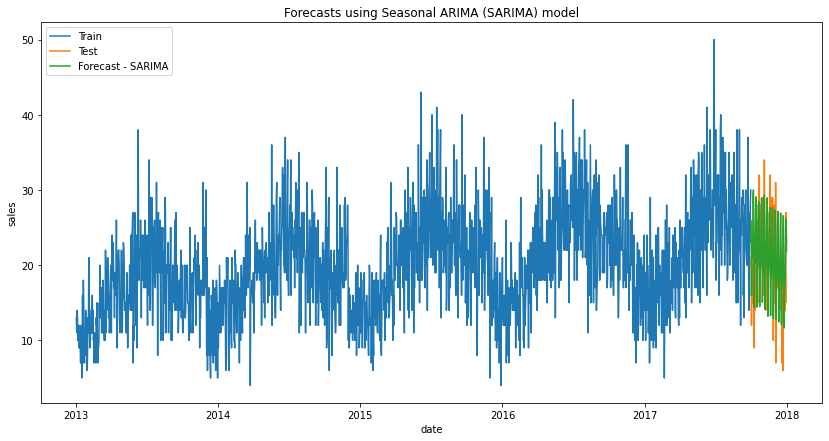

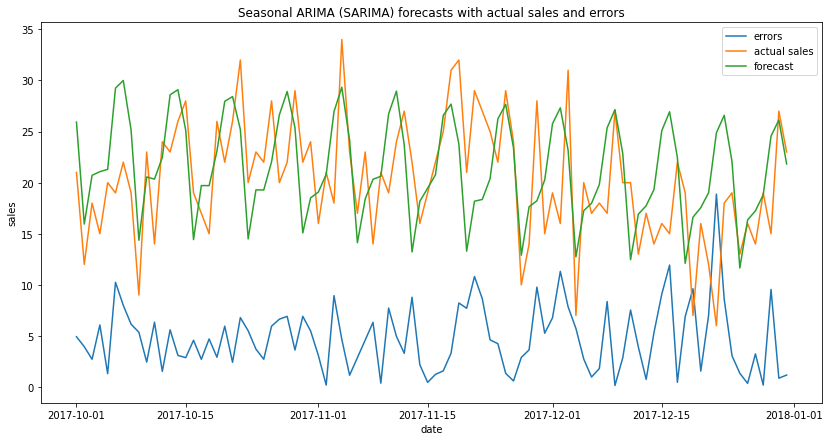

total_sales  total_pred_sales  SARIMA_overall_error       MAE  \
model                                                                   
SARIMA         1861       1973.197452           -112.197452  4.799933   

            RMSE       MAPE  
model                        
SARIMA  5.839147  23.728846

In [ ]:
# eval
arima_test_df['errors'] = arima_test_df.sales - arima_test_df.pred_sales
arima_test_df.insert(0, 'model', 'SARIMA')

# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='errors')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='actual sales')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual sales and errors')
plt.show()

result_df_sarima = arima_test_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          SARIMA_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_sarima

In [ ]:
MAE_SM=mae(np.abs(arima_test_df['errors']))
RMSE_SM=rmse(np.abs(arima_test_df['errors'])) 
MAPE_SM=mape(np.abs(arima_test_df['errors']))
print(MAE_SM)
print(RMSE_SM)
print(MAPE_SM)

4.7999329674195375
5.8391470191235015
23.72884648052646


###4. Supervised Machine Learning: Linear Regression

In [ ]:
reg_df = df
reg_df

date  store  item  sales  year  month  day  weekday
0    2013-01-01      1     1     13  2013      1    1        1
1    2013-01-02      1     1     11  2013      1    2        2
2    2013-01-03      1     1     14  2013      1    3        3
3    2013-01-04      1     1     13  2013      1    4        4
4    2013-01-05      1     1     10  2013      1    5        5
...         ...    ...   ...    ...   ...    ...  ...      ...
1821 2017-12-27      1     1     14  2017     12   27        2
1822 2017-12-28      1     1     19  2017     12   28        3
1823 2017-12-29      1     1     15  2017     12   29        4
1824 2017-12-30      1     1     27  2017     12   30        5
1825 2017-12-31      1     1     23  2017     12   31        6

[1826 rows x 8 columns]

###Step 1: Feature Engineering

In [ ]:
# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.sales.shift(i)
    
# Rolling window
reg_df['rolling_mean'] = reg_df.sales.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.sales.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.sales.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)
reg_df = reg_df.drop(['store', 'item'], axis=1)

# Split the series to predict the last 3 months of 2017
reg_df = reg_df.set_index('date')
reg_train_df = reg_df.loc[:'2017-09-30']                        
reg_test_df = reg_df.loc['2017-10-01':]

### Step 2: Feature Selection and Model Building

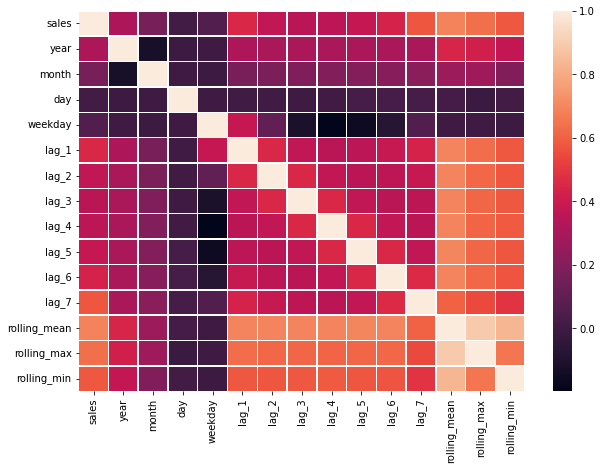

In [ ]:
# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sns.heatmap(corr, linewidths=.5)

In [ ]:
X_train = reg_train_df.drop(['sales'], axis=1)
y_train = reg_train_df['sales'].values

X_test = reg_test_df.drop(['sales'], axis=1)
y_test = reg_test_df['sales'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

         Feature        Score
11  rolling_mean  1577.946956
12   rolling_max  1170.464035
13   rolling_min   888.451268
10         lag_7   860.565955
4          lag_1   449.743115


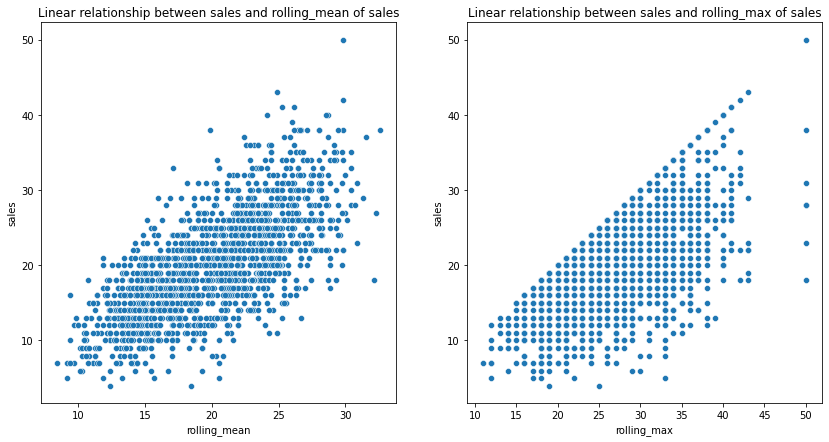

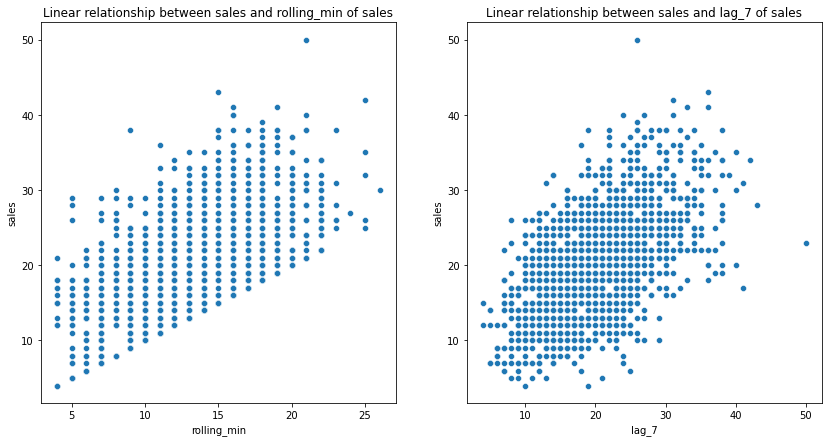

In [ ]:
# Checking for a linear relationship of the top features with sales (target variable)
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sns.scatterplot(reg_train_df.rolling_mean, reg_train_df.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sns.scatterplot(reg_train_df.rolling_max, reg_train_df.sales, ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sns.scatterplot(reg_train_df.rolling_min, reg_train_df.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sns.scatterplot(reg_train_df.lag_7, reg_train_df.sales, ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')

In [ ]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

###Step 3: Model Evaluation and Predictions

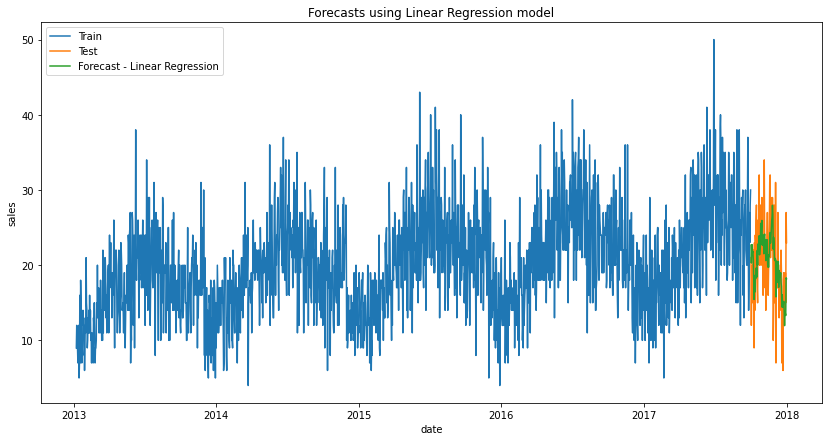

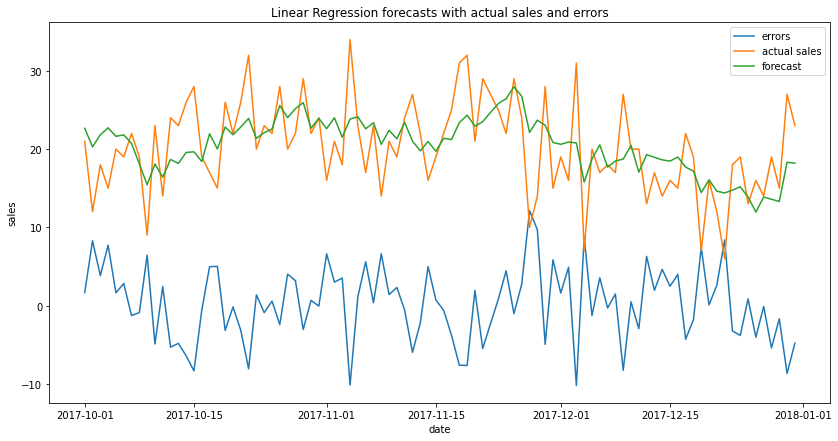

total_sales  total_pred_sales  LR_overall_error       MAE  \
model                                                                         
LinearRegression         1861       1882.074831         21.074831  3.858646   

                      RMSE       MAPE  
model                                  
LinearRegression  4.786183  19.075519

In [ ]:
# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

result_df_lr = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr

In [ ]:
MAE_LR=mae(errors_df.errors)
RMSE_LR=rmse(errors_df.errors) 
MAPE_LR=mape(errors_df.errors)
print(MAE_LR)
print(RMSE_LR)
print(MAPE_LR)

3.8586457256438615
4.786183105948845
19.07551890162468


###5. Decision Tree Regressor


In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Fit regression model
regr = DecisionTreeRegressor(max_depth=2)
regr.fit(X_train, y_train)

# Predict
preds1 = regr.predict(X_test)

errors_df1 = reg_test_df[['sales']]
errors_df1['pred_sales'] = preds1
errors_df1['errors'] = preds1 - y_test
errors_df1.insert(0, 'regr', 'DecisionTreeRegressor')

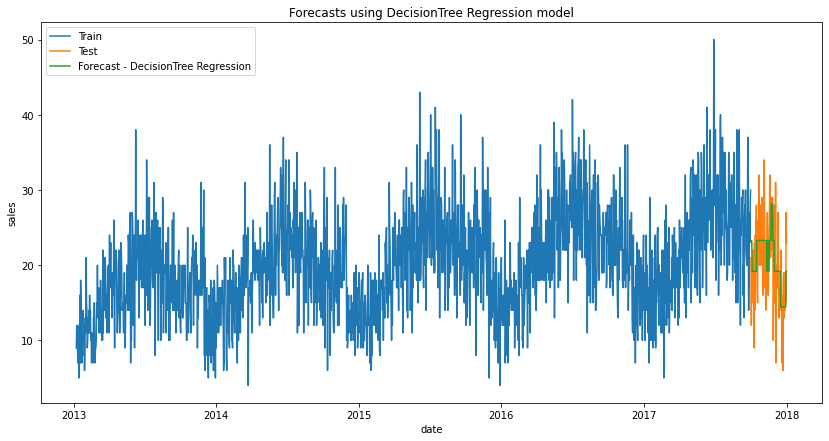

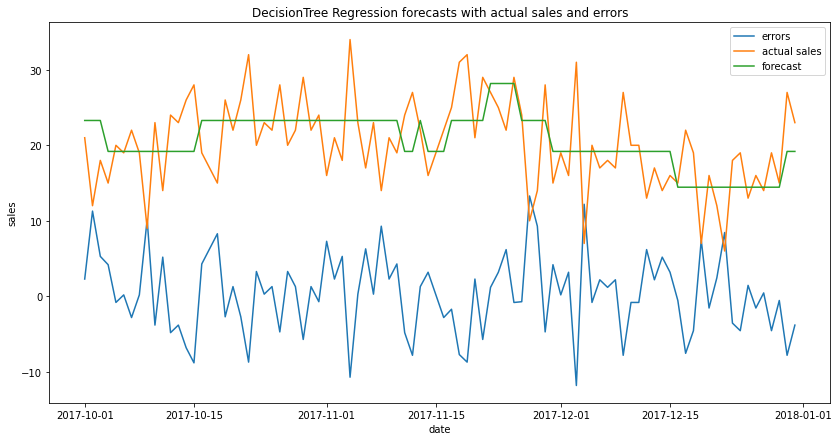

total_sales  total_pred_sales  LR_overall_error  \
regr                                                                     
DecisionTreeRegressor         1861       1894.781056         33.781056   

                            MAE      RMSE       MAPE  
regr                                                  
DecisionTreeRegressor  4.189993  5.294698  20.713558

In [ ]:
# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df1.index, errors_df1['pred_sales'], label='Forecast - DecisionTree Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using DecisionTree Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df1.index, errors_df1.errors, label='errors')
plt.plot(errors_df1.index, errors_df1.sales, label='actual sales')
plt.plot(errors_df1.index, errors_df1.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('DecisionTree Regression forecasts with actual sales and errors')
plt.show()

result_df_lr1 = errors_df1.groupby('regr').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr1

In [ ]:
MAE_DTR=mae(errors_df1.errors)
RMSE_DTR=rmse(errors_df1.errors) 
MAPE_DTR=mape(errors_df1.errors)
print(MAE_DTR)
print(RMSE_DTR)
print(MAPE_DTR)

4.189992593228399
5.294698269375921
20.7135582255246


###6. Support Vector Regressor

In [ ]:
from sklearn.svm import SVR
# Fit regression model
svr = SVR()
svr.fit(X_train, y_train)

# Predict
preds2 = svr.predict(X_test)

errors_df2 = reg_test_df[['sales']]
errors_df2['pred_sales'] = preds2
errors_df2['errors'] = preds2 - y_test
errors_df2.insert(0, 'svr', 'SupportVectorRegressor')

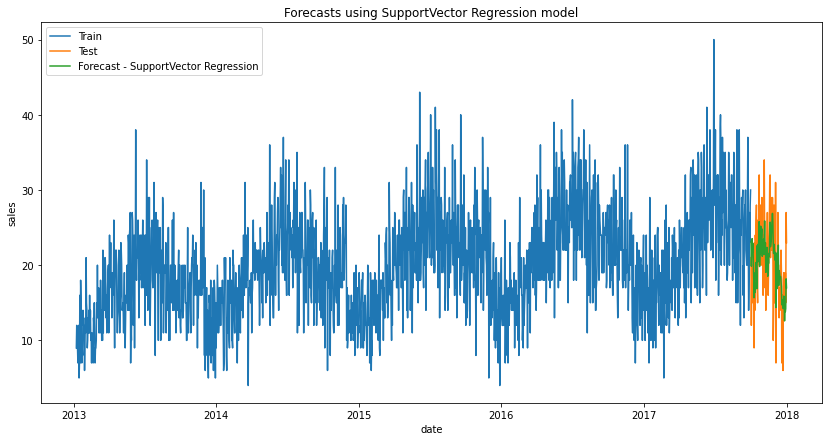

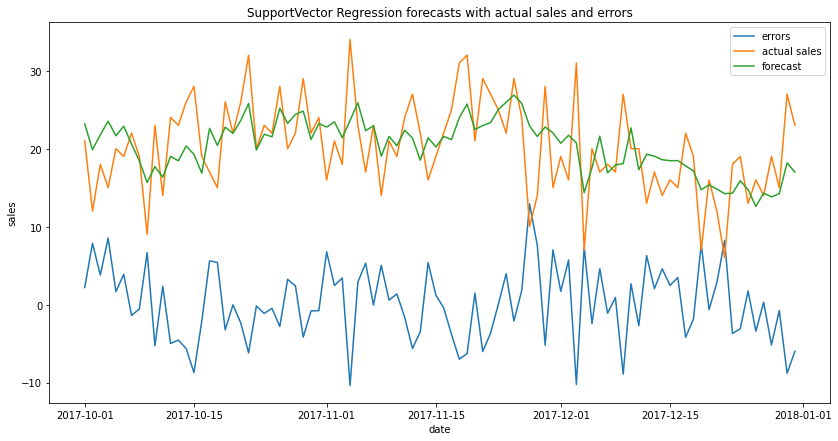

total_sales  total_pred_sales  LR_overall_error  \
svr                                                                       
SupportVectorRegressor         1861       1872.023958         11.023958   

                             MAE      RMSE       MAPE  
svr                                                    
SupportVectorRegressor  3.910723  4.776338  19.332966

In [ ]:
#eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df2.index, errors_df2['pred_sales'], label='Forecast - SupportVector Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using SupportVector Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df2.index, errors_df2.errors, label='errors')
plt.plot(errors_df2.index, errors_df2.sales, label='actual sales')
plt.plot(errors_df2.index, errors_df2.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('SupportVector Regression forecasts with actual sales and errors')
plt.show()

result_df_lr2 = errors_df2.groupby('svr').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr2

In [ ]:
MAE_SVR=mae(errors_df2.errors)
RMSE_SVR=rmse(errors_df2.errors) 
MAPE_SVR=mape(errors_df2.errors)
print(MAE_SVR)
print(RMSE_SVR)
print(MAPE_SVR)

3.910722739399541
4.776337841384553
19.3329657186866


###7. Lasso Regressor

In [ ]:
from sklearn import linear_model

# Fit regression model
lassoReg = linear_model.Lasso(alpha=0.1)
lassoReg.fit(X_train, y_train)

# Predict
preds3 = lassoReg.predict(X_test)

errors_df3 = reg_test_df[['sales']]
errors_df3['pred_sales'] = preds3
errors_df3['errors'] = preds3 - y_test
errors_df3.insert(0, 'lassoReg', 'LassoRegressor')

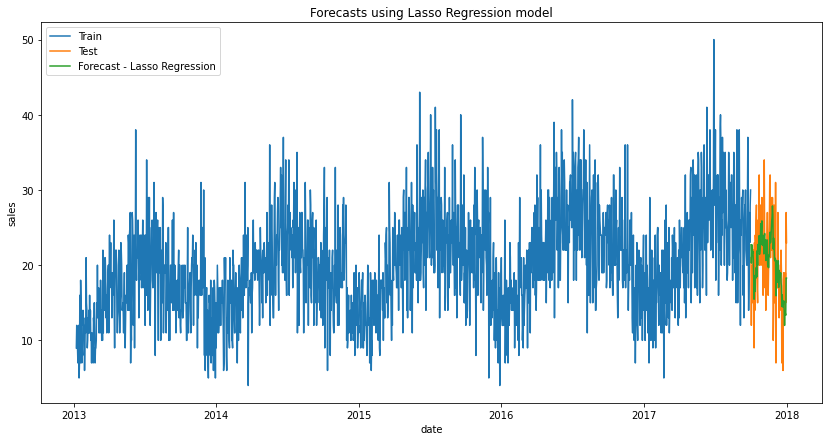

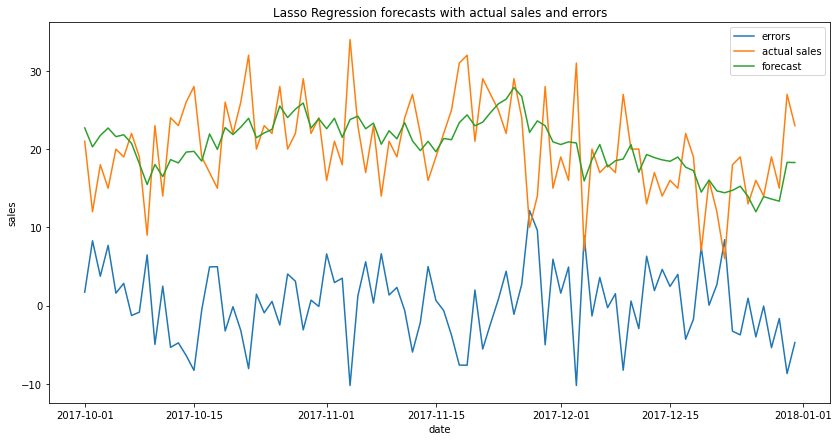

total_sales  total_pred_sales  LR_overall_error      MAE  \
lassoReg                                                                   
LassoRegressor         1861       1881.995677         20.995677  3.86072   

                   RMSE       MAPE  
lassoReg                            
LassoRegressor  4.78824  19.085774

In [ ]:
#eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df3.index, errors_df3['pred_sales'], label='Forecast - Lasso Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Lasso Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df3.index, errors_df3.errors, label='errors')
plt.plot(errors_df3.index, errors_df3.sales, label='actual sales')
plt.plot(errors_df3.index, errors_df3.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Lasso Regression forecasts with actual sales and errors')
plt.show()

result_df_lr3 = errors_df3.groupby('lassoReg').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr3

In [ ]:
MAE_LAR=mae(errors_df3.errors)
RMSE_LAR=rmse(errors_df3.errors) 
MAPE_LAR=mape(errors_df3.errors)
print(MAE_LAR)
print(RMSE_LAR)
print(MAPE_LAR)

3.860720234306595
4.78824041649854
19.08577439850655


###8. Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Fit regression model
rfr = RandomForestRegressor(max_depth=3)
rfr.fit(X_train, y_train)

# Predict
preds4 = rfr.predict(X_test)

errors_df4 = reg_test_df[['sales']]
errors_df4['pred_sales'] = preds4
errors_df4['errors'] = preds4 - y_test
errors_df4.insert(0, 'rfr', 'RandomForestRegressor')

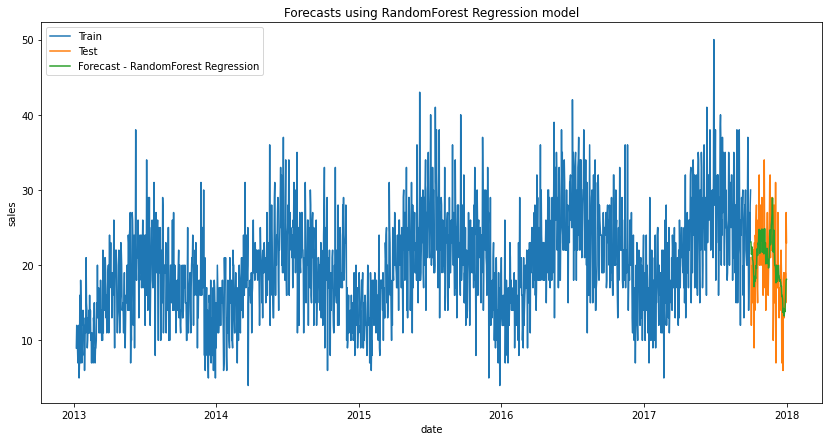

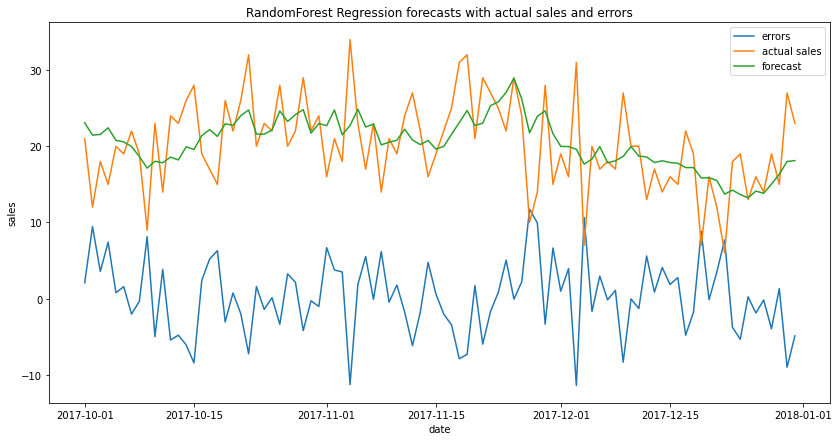

total_sales  total_pred_sales  LR_overall_error  \
rfr                                                                      
RandomForestRegressor         1861       1882.417049         21.417049   

                            MAE      RMSE       MAPE  
rfr                                                   
RandomForestRegressor  3.852026  4.900209  19.042792

In [ ]:
#eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df4.index, errors_df4['pred_sales'], label='Forecast - RandomForest Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using RandomForest Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df4.index, errors_df4.errors, label='errors')
plt.plot(errors_df4.index, errors_df4.sales, label='actual sales')
plt.plot(errors_df4.index, errors_df4.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('RandomForest Regression forecasts with actual sales and errors')
plt.show()

result_df_lr4 = errors_df4.groupby('rfr').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr4

In [ ]:
MAE_RFR=mae(errors_df4.errors)
RMSE_RFR=rmse(errors_df4.errors) 
MAPE_RFR=mape(errors_df4.errors)
print(MAE_RFR)
print(RMSE_RFR)
print(MAPE_RFR)

3.852025695833217
4.90020893749658
19.04279226311962


###9. XGBoost

In [ ]:
import xgboost as xgb

# Fit regression model
my_xgb = xgb.XGBRegressor()
my_xgb.fit(X_train, y_train)

# Predict
preds5 = my_xgb.predict(X_test)

errors_df5 = reg_test_df[['sales']]
errors_df5['pred_sales'] = preds5
errors_df5['errors'] = preds5 - y_test
errors_df5.insert(0, 'my_xgb', 'XGBoostRegressor')

[00:45:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


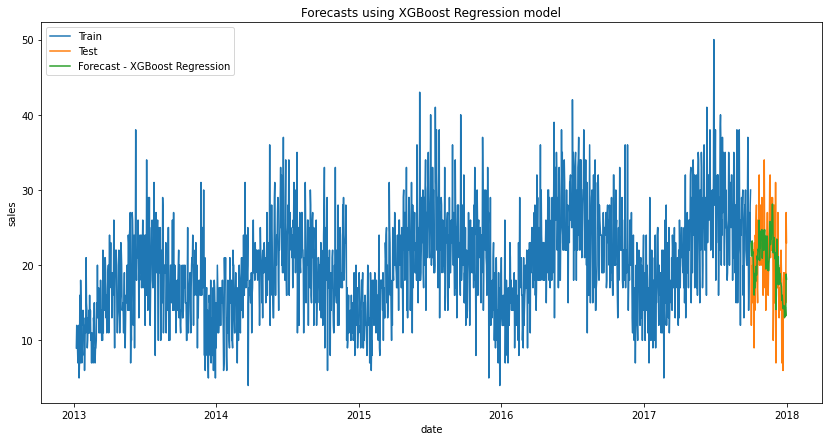

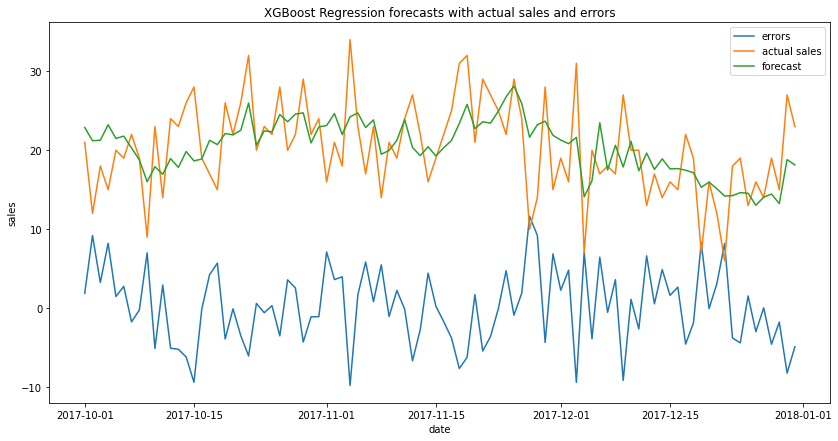

total_sales  total_pred_sales  LR_overall_error       MAE  \
my_xgb                                                                        
XGBoostRegressor         1861        1877.15564         16.155643  3.931174   

                      RMSE       MAPE  
my_xgb                                 
XGBoostRegressor  4.820058  19.434067

In [ ]:
#eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df5.index, errors_df5['pred_sales'], label='Forecast - XGBoost Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using XGBoost Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df5.index, errors_df5.errors, label='errors')
plt.plot(errors_df5.index, errors_df5.sales, label='actual sales')
plt.plot(errors_df5.index, errors_df5.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('XGBoost Regression forecasts with actual sales and errors')
plt.show()

result_df_lr5 = errors_df5.groupby('my_xgb').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr5

In [ ]:
MAE_XGBR=mae(errors_df5.errors)
RMSE_XGBR=rmse(errors_df5.errors) 
MAPE_XGBR=mape(errors_df5.errors)
print(MAE_XGBR)
print(RMSE_XGBR)
print(MAPE_XGBR)

3.931173801422119
4.820058486176756
19.434067153725685


###10. ExtraTreeRegressor 

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

# Fit regression model
extr = ExtraTreesRegressor()
extr.fit(X_train, y_train)

# Predict
preds6 = extr.predict(X_test)

errors_df6 = reg_test_df[['sales']]
errors_df6['pred_sales'] = preds6
errors_df6['errors'] = preds6 - y_test
errors_df6.insert(0, 'extr', 'ExtraTreesRegressor')

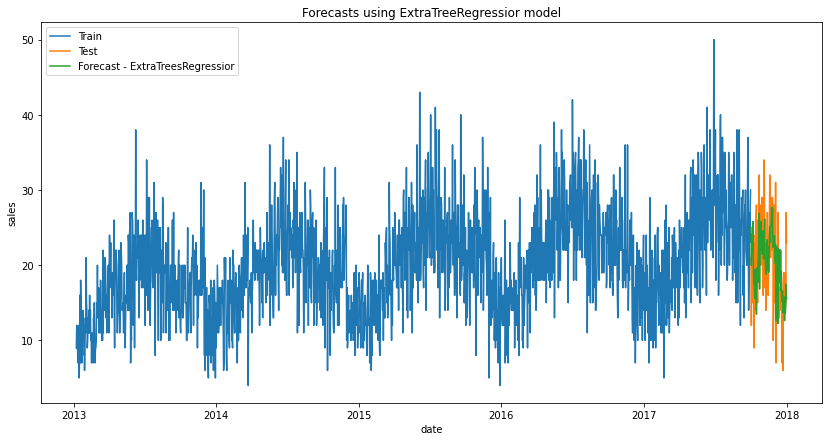

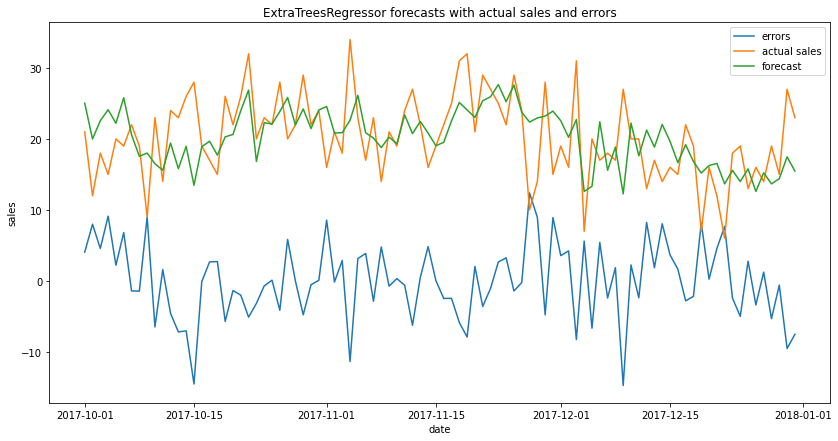

total_sales  total_pred_sales  LR_overall_error  \
extr                                                                   
ExtraTreesRegressor         1861          1860.535            -0.465   

                          MAE      RMSE       MAPE  
extr                                                
ExtraTreesRegressor  4.242554  5.374113  20.973401

In [ ]:
#eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df6.index, errors_df6['pred_sales'], label='Forecast - ExtraTreesRegressior')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using ExtraTreeRegressior model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df6.index, errors_df6.errors, label='errors')
plt.plot(errors_df6.index, errors_df6.sales, label='actual sales')
plt.plot(errors_df6.index, errors_df6.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('ExtraTreesRegressor forecasts with actual sales and errors')
plt.show()

result_df_lr6 = errors_df6.groupby('extr').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr6

In [ ]:
MAE_ETR=mae(errors_df6.errors)
RMSE_ETR=rmse(errors_df6.errors) 
MAPE_ETR=mape(errors_df6.errors)
print(MAE_ETR)
print(RMSE_ETR)
print(MAPE_ETR)

4.242554347826089
5.374112692180995
20.973401397098332


###11. Huber Regressor 

In [ ]:

from sklearn.linear_model import HuberRegressor

# Fit regression model
hubr = HuberRegressor()
hubr.fit(X_train, y_train)

# Predict
preds7 = hubr.predict(X_test)

errors_df7 = reg_test_df[['sales']]
errors_df7['pred_sales'] = preds7
errors_df7['errors'] = preds7 - y_test
errors_df7.insert(0, 'hubr', 'HuberRegressor')


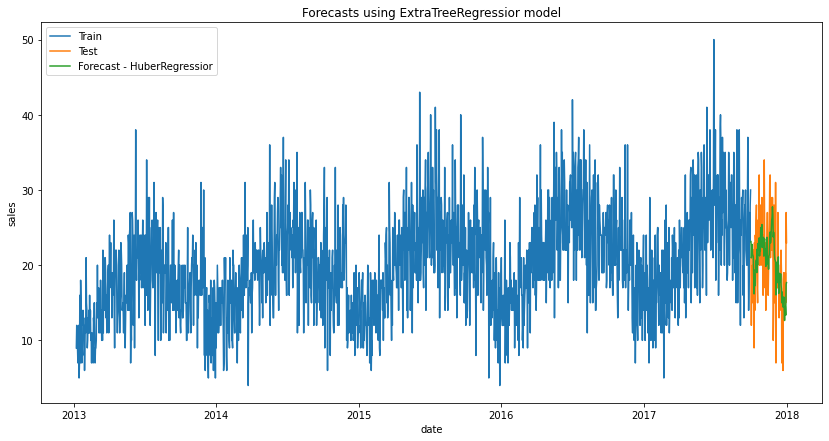

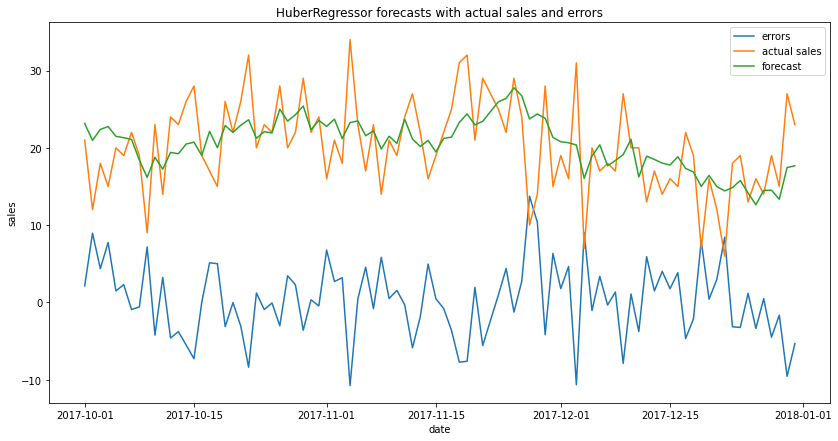

total_sales  total_pred_sales  LR_overall_error       MAE  \
hubr                                                                        
HuberRegressor         1861       1884.329434         23.329434  3.799775   

                    RMSE       MAPE  
hubr                                 
HuberRegressor  4.820042  18.784489

In [ ]:
#eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df7.index, errors_df7['pred_sales'], label='Forecast - HuberRegressior')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using ExtraTreeRegressior model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df7.index, errors_df7.errors, label='errors')
plt.plot(errors_df7.index, errors_df7.sales, label='actual sales')
plt.plot(errors_df7.index, errors_df7.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('HuberRegressor forecasts with actual sales and errors')
plt.show()

result_df_lr7 = errors_df7.groupby('hubr').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr7

In [ ]:
MAE_HR=mae(errors_df7.errors)
RMSE_HR=rmse(errors_df7.errors) 
MAPE_HR=mape(errors_df7.errors)
print(MAE_HR)
print(RMSE_HR)
print(MAPE_HR)

3.7997754156553927
4.820041995168953
18.784488889860082


###12. RANSAC Regressor 

In [ ]:
from sklearn.linear_model import RANSACRegressor
# Fit regression model
ransac = RANSACRegressor()
ransac.fit(X_train, y_train)

# Predict
preds8 = ransac.predict(X_test)

errors_df8 = reg_test_df[['sales']]
errors_df8['pred_sales'] = preds8
errors_df8['errors'] = preds8 - y_test
errors_df8.insert(0, 'ransac', 'RANSACRegressor')


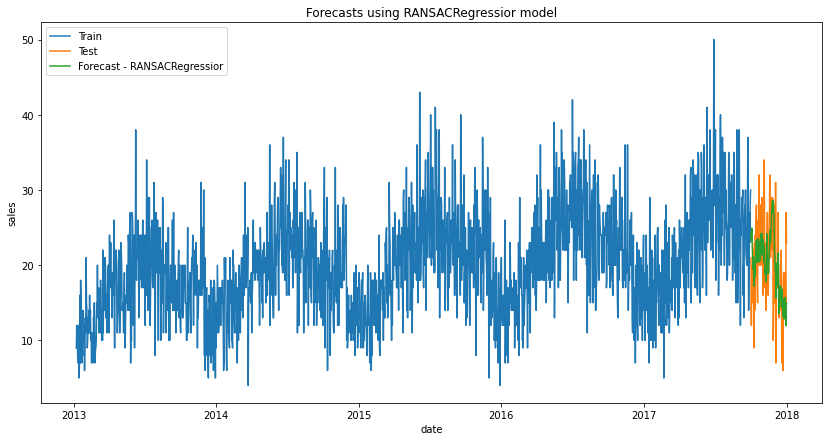

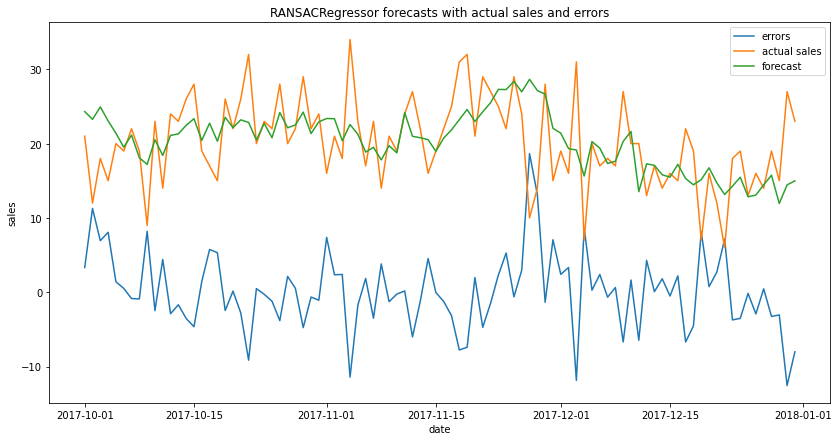

total_sales  total_pred_sales  LR_overall_error       MAE  \
ransac                                                                       
RANSACRegressor         1861       1870.414249          9.414249  3.823544   

                     RMSE      MAPE  
ransac                               
RANSACRegressor  5.193798  18.90199

In [ ]:
#eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df8.index, errors_df8['pred_sales'], label='Forecast - RANSACRegressior')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using RANSACRegressior model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df8.index, errors_df8.errors, label='errors')
plt.plot(errors_df8.index, errors_df8.sales, label='actual sales')
plt.plot(errors_df8.index, errors_df8.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('RANSACRegressor forecasts with actual sales and errors')
plt.show()

result_df_lr8 = errors_df8.groupby('ransac').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr8

In [ ]:
MAE_RSR=mae(errors_df8.errors)
RMSE_RSR=rmse(errors_df8.errors) 
MAPE_RSR=mape(errors_df8.errors)
print(MAE_RSR)
print(RMSE_RSR)
print(MAPE_RSR)

3.823543810102998
5.193797754335122
18.901989818886385


###13.TheilSen Regressor 

In [ ]:
from sklearn.linear_model import TheilSenRegressor
# Fit regression model
theil = TheilSenRegressor()
theil.fit(X_train, y_train)

# Predict
preds9 = theil.predict(X_test)

errors_df9 = reg_test_df[['sales']]
errors_df9['pred_sales'] = preds9
errors_df9['errors'] = preds9 - y_test
errors_df9.insert(0, 'theil', 'TheilSenRegressor')

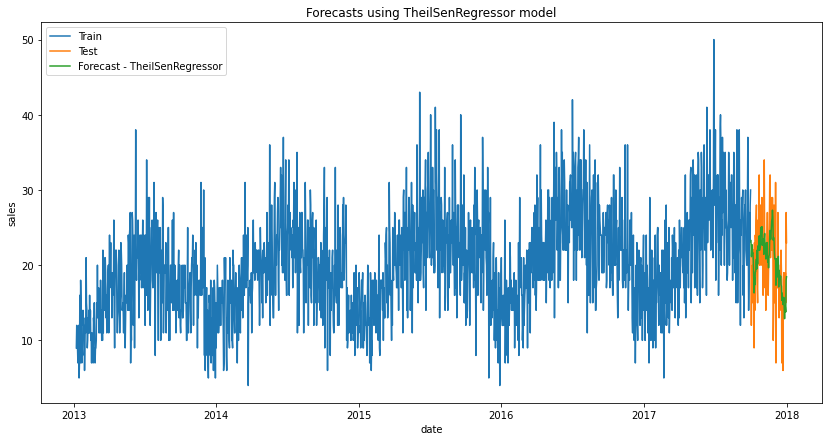

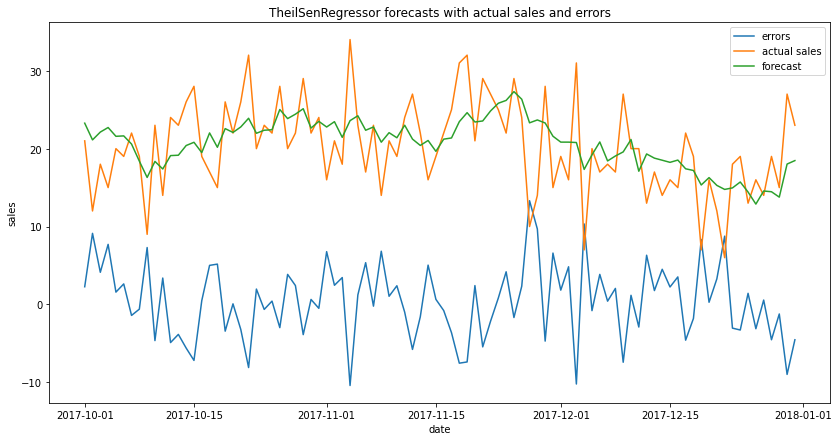

total_sales  total_pred_sales  LR_overall_error       MAE  \
theil                                                                          
TheilSenRegressor         1861       1899.700302         38.700302  3.891755   

                       RMSE       MAPE  
theil                                   
TheilSenRegressor  4.847723  19.239197

In [ ]:
#eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df9.index, errors_df9['pred_sales'], label='Forecast - TheilSenRegressor')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using TheilSenRegressor model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df9.index, errors_df9.errors, label='errors')
plt.plot(errors_df9.index, errors_df9.sales, label='actual sales')
plt.plot(errors_df9.index, errors_df9.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('TheilSenRegressor forecasts with actual sales and errors')
plt.show()

result_df_lr9 = errors_df9.groupby('theil').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr9

In [ ]:
MAE_TSR=mae(errors_df9.errors)
RMSE_TSR=rmse(errors_df9.errors) 
MAPE_TSR=mape(errors_df9.errors)
print(MAE_TSR)
print(RMSE_TSR)
print(MAPE_TSR)

3.8917550383360955
4.847722663165494
19.239197395320843


In [ ]:
!pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tabulate import tabulate

In [ ]:
from sklearn.ensemble import VotingRegressor

In [ ]:
models1 = [('Linear Regression', LinearRegression()),
           ('Huber Regression', HuberRegressor()),
           ('Support Vector Regression', SVR()),
           ('RANSAC Regression', RANSACRegressor())]
score = []

In [ ]:
ensemble = VotingRegressor(estimators=models)
ensemble.fit(X_train, y_train)
prediction13 = ensemble.predict(X_test)
#score = mean_squared_error(y_test, prediction13, squared = False)
#print('Ensemble Model RMSE: {}'.format(score))

errors_df98 = reg_test_df[['sales']]
errors_df98['pred_sales'] = prediction13
errors_df98['errors'] = prediction13 - y_test
errors_df98.insert(0, 'Ensemble', 'ensemble')

In [ ]:
MAE_ensemble=mae(errors_df98.errors)
RMSE_ensemble=rmse(errors_df98.errors) 
MAPE_ensemble=mape(errors_df98.errors)
print(MAE_ensemble)
print(RMSE_ensemble)
print(MAPE_ensemble)

3.777324778669609
4.821318839284402
18.67350239858161


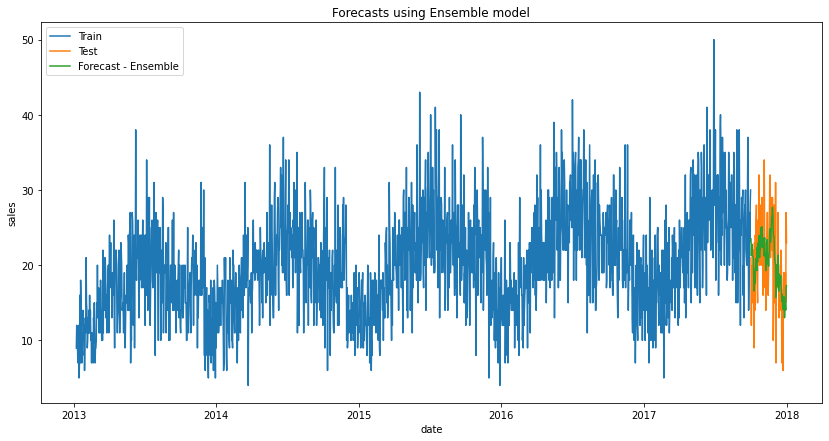

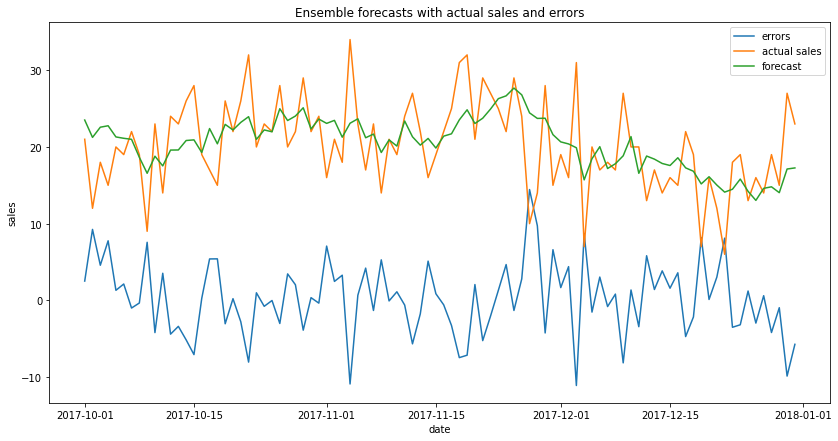

KeyError: ignored

In [ ]:
#eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df98.index, errors_df98['pred_sales'], label='Forecast - Ensemble')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Ensemble model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df98.index, errors_df98.errors, label='errors')
plt.plot(errors_df98.index, errors_df98.sales, label='actual sales')
plt.plot(errors_df98.index, errors_df98.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Ensemble forecasts with actual sales and errors')
plt.show()

result_df_lr98 = errors_df98.groupby('ensemble').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr98

In [ ]:
models2 = [#('Linear Regression', LinearRegression()),
           #('Random Forest Regressor', RandomForestRegressor()),
           ('Xgboost Regressor', xgb.XGBRegressor()),
           #('lasso Regression', linear_model.Lasso(alpha=0.1)),
           ('Huber Regression', HuberRegressor()),
           #('Support Vector Regression', SVR()),
           ('RANSAC Regression', RANSACRegressor())]

In [ ]:
ensemble1 = VotingRegressor(estimators=models2)
ensemble1.fit(X_train, y_train)
prediction14 = ensemble1.predict(X_test)
#score = mean_squared_error(y_test, prediction13, squared = False)
#print('Ensemble Model RMSE: {}'.format(score))

errors_df99 = reg_test_df[['sales']]
errors_df99['pred_sales'] = prediction14
errors_df99['errors'] = prediction14 - y_test
errors_df99.insert(0, 'Ensemble', 'ensemble1')

MAE_ensemble1=mae(errors_df99.errors)
RMSE_ensemble1=rmse(errors_df99.errors) 
MAPE_ensemble1=mape(errors_df99.errors)
print(MAE_ensemble1)
print(RMSE_ensemble1)
print(MAPE_ensemble1)

[02:51:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3.790983649013812
4.835292158360266
18.741026099369737


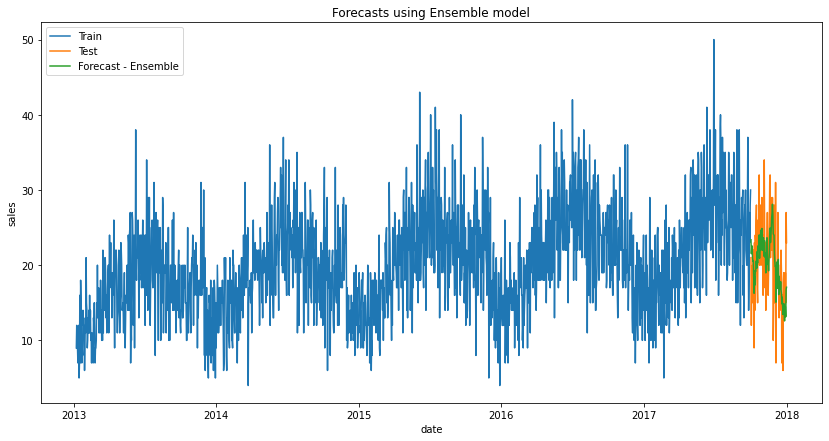

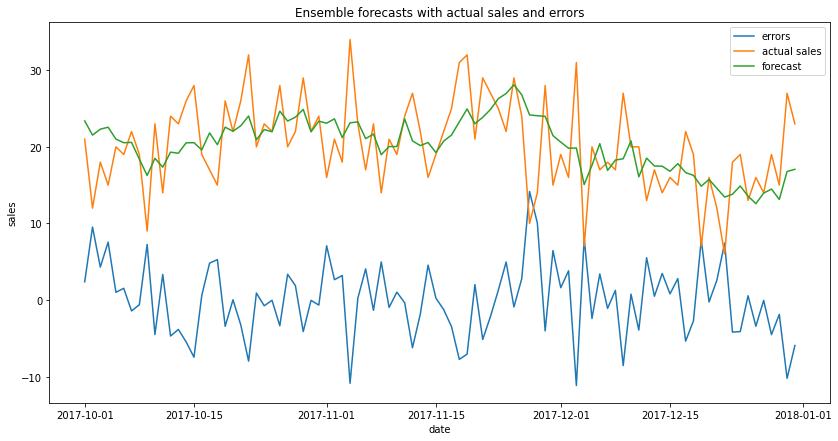

KeyError: ignored

In [ ]:
#eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df99.index, errors_df99['pred_sales'], label='Forecast - Ensemble')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Ensemble model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df99.index, errors_df99.errors, label='errors')
plt.plot(errors_df99.index, errors_df99.sales, label='actual sales')
plt.plot(errors_df99.index, errors_df99.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Ensemble forecasts with actual sales and errors')
plt.show()

result_df_lr99 = errors_df99.groupby('ensemble1').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr99

In [ ]:
models3 = [('Linear Regression', LinearRegression()),
           #('Random Forest Regressor', RandomForestRegressor()),
           ('Xgboost Regressor', xgb.XGBRegressor()),
           #('lasso Regression', linear_model.Lasso(alpha=0.1)),
           ('Huber Regression', HuberRegressor())]
           #('Support Vector Regression', SVR()),
           #('RANSAC Regression', RANSACRegressor())]

In [ ]:
ensemble2 = VotingRegressor(estimators=models3)
ensemble2.fit(X_train, y_train)
prediction15 = ensemble2.predict(X_test)
#score = mean_squared_error(y_test, prediction13, squared = False)
#print('Ensemble Model RMSE: {}'.format(score))

errors_df100 = reg_test_df[['sales']]
errors_df100['pred_sales'] = prediction15
errors_df100['errors'] = prediction15 - y_test
errors_df100.insert(0, 'Ensemble', 'ensemble2')

MAE_ensemble2=mae(errors_df100.errors)
RMSE_ensemble2=rmse(errors_df100.errors) 
MAPE_ensemble2=mape(errors_df100.errors)
print(MAE_ensemble2)
print(RMSE_ensemble2)
print(MAPE_ensemble2)

[02:55:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3.8404055132842534
4.78563851300351
18.98534697593506


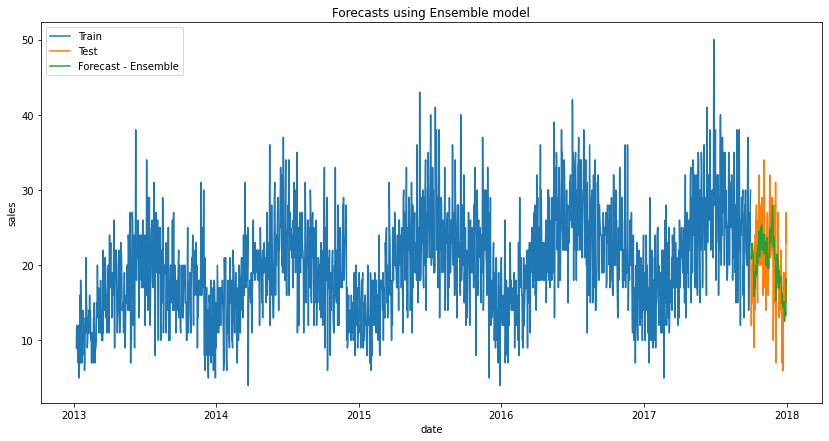

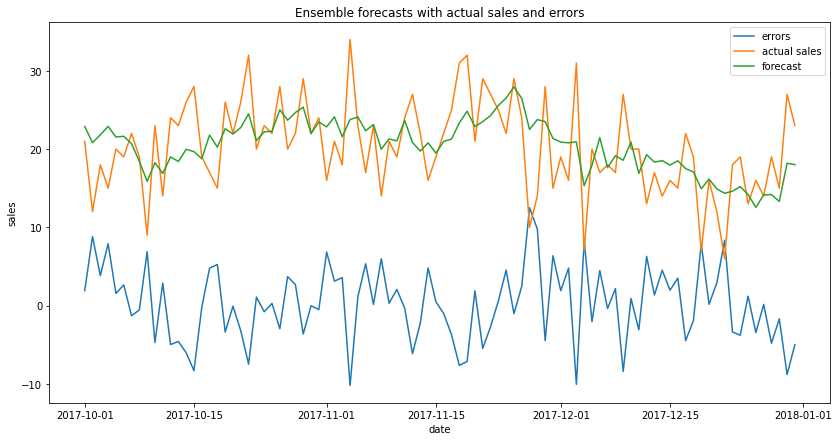

KeyError: ignored

In [ ]:
#eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df100.index, errors_df100['pred_sales'], label='Forecast - Ensemble')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Ensemble model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df100.index, errors_df100.errors, label='errors')
plt.plot(errors_df100.index, errors_df100.sales, label='actual sales')
plt.plot(errors_df100.index, errors_df100.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Ensemble forecasts with actual sales and errors')
plt.show()

result_df_lr100 = errors_df100.groupby('ensemble2').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr100

In [ ]:
table = [['Model Name', 'MAE','RMSE','MAPE'], 
         ['Holt winters w/o damping', MAE_hwwtd, RMSE_hwwtd, MAPE_hwwtd],
         ['Holt winters with damping', MAE_htd, RMSE_htd, MAPE_htd],
         ['SARIMA ', MAE_SM, RMSE_SM, MAPE_SM],
         ['Linear Regression',MAE_LR, RMSE_LR, MAPE_LR],
         ['Decision Tree', MAE_DTR, RMSE_DTR, MAPE_DTR],
         ['Random Forest', MAE_RFR, RMSE_RFR, MAPE_RFR],
         ['SVR', MAE_SVR, RMSE_SVR, MAPE_SVR],
         ['Lasso Regression', MAE_LAR, RMSE_LAR, MAPE_LAR],
         ['XGBoost', MAE_XGBR, RMSE_XGBR, MAPE_XGBR],
         ['ExtraTree Regression', MAE_ETR, RMSE_ETR, MAPE_ETR],
         ['Huber Regression', MAE_HR, RMSE_HR, MAPE_HR],
         ['RANSAC Regression', MAE_RSR, RMSE_RSR, MAPE_RSR],
         ['TheilSen Regression', MAE_TSR, RMSE_TSR, MAPE_TSR],
         ['Hybrid Ensemble Model', MAE_ensemble2, RMSE_ensemble2, MAPE_ensemble2],
         ['Hybrid Ensemble Model1', MAE_ensemble1, RMSE_ensemble1, MAPE_ensemble1],
         ['Hybrid Ensemble Model2', MAE_ensemble, RMSE_ensemble, MAPE_ensemble]
         ]

In [ ]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid',showindex=range(1,17)))

╒════╤═══════════════════════════╤═════════╤═════════╤═════════╕
│    │ Model Name                │     MAE │    RMSE │    MAPE │
╞════╪═══════════════════════════╪═════════╪═════════╪═════════╡
│  1 │ Holt winters w/o damping  │ 4.62932 │ 5.82743 │ 22.8854 │
├────┼───────────────────────────┼─────────┼─────────┼─────────┤
│  2 │ Holt winters with damping │ 6.01619 │ 7.31962 │ 29.7415 │
├────┼───────────────────────────┼─────────┼─────────┼─────────┤
│  3 │ SARIMA                    │ 4.79993 │ 5.83915 │ 23.7288 │
├────┼───────────────────────────┼─────────┼─────────┼─────────┤
│  4 │ Linear Regression         │ 3.85865 │ 4.78618 │ 19.0755 │
├────┼───────────────────────────┼─────────┼─────────┼─────────┤
│  5 │ Decision Tree             │ 4.18999 │ 5.2947  │ 20.7136 │
├────┼───────────────────────────┼─────────┼─────────┼─────────┤
│  6 │ Random Forest             │ 3.85203 │ 4.90021 │ 19.0428 │
├────┼───────────────────────────┼─────────┼─────────┼─────────┤
│  7 │ SVR               